In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Dense, Flatten, Dropout, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from random import sample

# Loading Dataset

In [3]:
breast_img = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png


# Visualizing Dataset

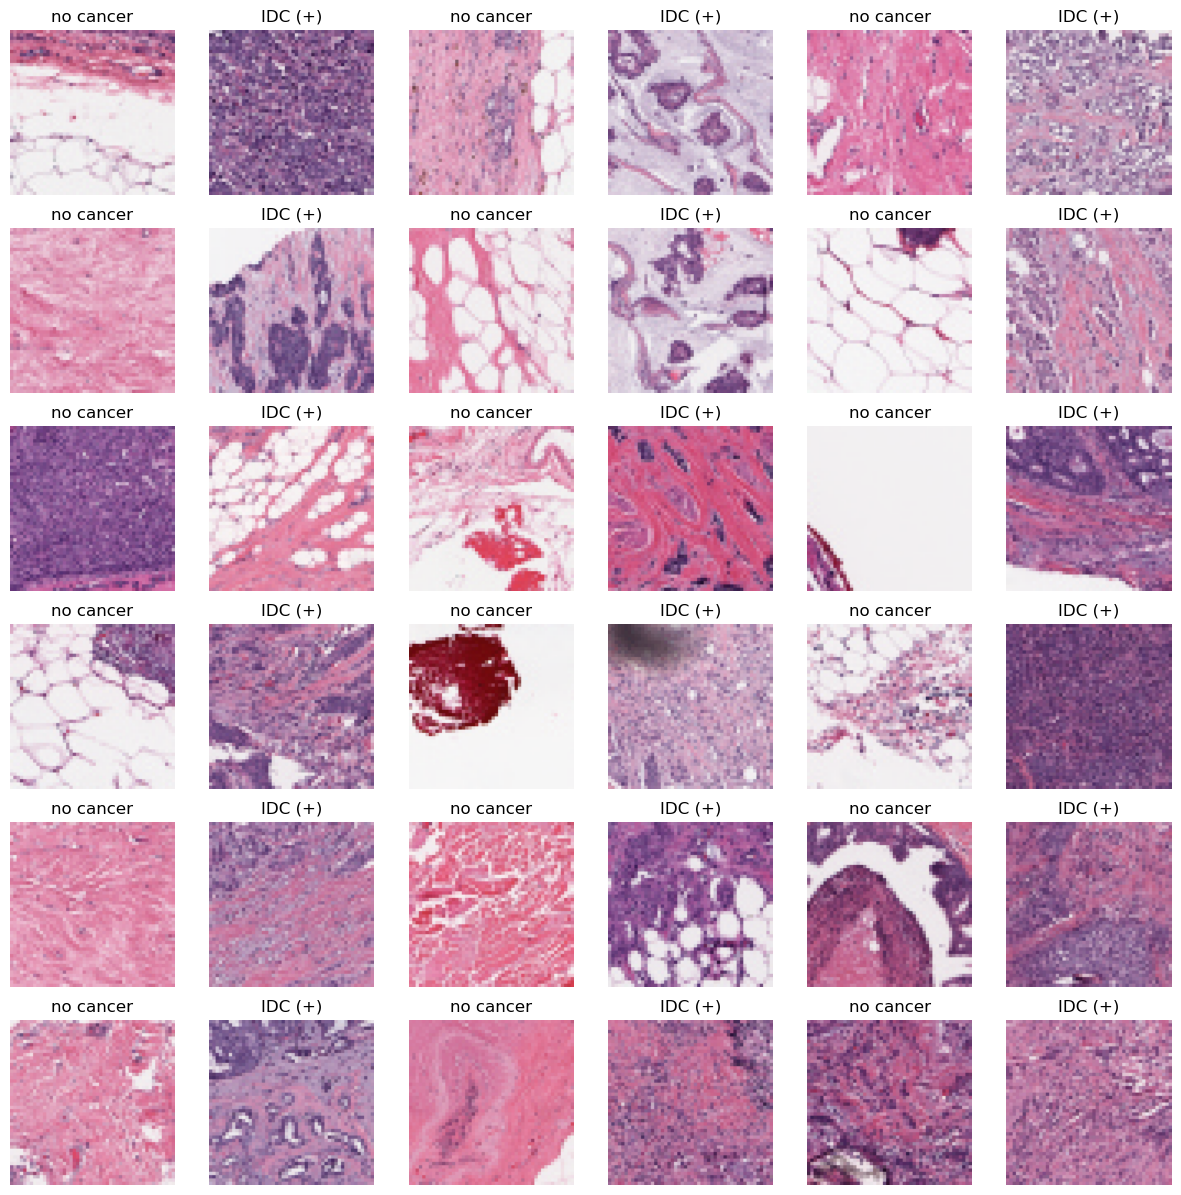

In [4]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)
    
    elif img[-5] == '1' :
        P_IDC.append(img)
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:
    
        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:
    
        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1


In [5]:
NewN_IDC=N_IDC[:78786]
print(len(NewN_IDC))
print(len(P_IDC))

78786
78786


# Data Preprocessing

In [6]:
total = len(N_IDC) + len(P_IDC)
ppos = len(P_IDC)/total
desired = 40000
psamp = desired/total
print(total, ppos, desired, psamp)

non_img_arr = []
can_img_arr = []
non_y = []
can_y = []

# downsample to limit RAM usage
for i,img in enumerate(N_IDC):
    if (np.random.uniform() < psamp):
      n_img = cv2.imread(img, cv2.IMREAD_COLOR)
      n_img = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
      non_img_arr.append(n_img)
      non_y.append(0)

for i,img in enumerate(P_IDC):
    if (np.random.uniform() < psamp):
      c_img = cv2.imread(img, cv2.IMREAD_COLOR)
      c_img = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
      can_img_arr.append(c_img)
      can_y.append(1)

X = np.concatenate((non_img_arr, can_img_arr))
y = np.concatenate([non_y,can_y])

277524 0.28388896095472826 40000 0.14413167870166183


In [7]:
non_img_arr = []
can_img_arr = []

for img in NewN_IDC:
        
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])
    
for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

In [9]:
print(len(non_img_arr))
print(len(can_img_arr))

78786
78786


In [10]:
X = []
y = []

breast_img_arr = np.concatenate((non_img_arr[:12389], can_img_arr[:12389]))
random.shuffle(breast_img_arr)

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [11]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y[train_index], y[test_index]

In [12]:
# Convert labels to one-hot encoded format
Y_train = to_categorical(Y_train, num_classes=2)
Y_test = to_categorical(Y_test, num_classes=2)

In [13]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,y)

Total number of images: 24778
Number of IDC(-) Images: 20941
Number of IDC(+) Images: 3837
Image shape (Width, Height, Channels): (50, 50, 3)


In [14]:
data_generator = ImageDataGenerator(
    rotation_range=30,  # Rotate images by up to 30 degrees
    width_shift_range=0.1,  # Shift horizontally by up to 10% of the image width
    height_shift_range=0.1,  # Shift vertically by up to 10% of the image height
    shear_range=0.2,  # Apply shear transformation
    zoom_range=0.2,  # Randomly zoom in or out by up to 20%
    horizontal_flip=True,  # Flip images horizontally
    vertical_flip=False,  # Don't flip images vertically
    fill_mode='nearest'  # Fill newly created pixels with the nearest pixel value
)

In [15]:
X_train_augmented = data_generator.flow(X_train, Y_train, batch_size=32)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)
print("Training Data Shape:", X_train.shape)

Training Data Shape: (17344, 50, 50, 3)


In [17]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
print("Testing Data Shape:", X_test.shape)

Testing Data Shape: (7434, 50, 50, 3)


# Modeling

In [18]:
from tensorflow.keras.applications.resnet import ResNet50

# Load the ResNet50 model pre-trained on ImageNet
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Freeze all layers except the top 4 layers
for layer in resnet_model.layers[:-4]:
    layer.trainable = False

# Create a new model by adding custom layers on top of the ResNet50 model
model = Sequential()
model.add(resnet_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Set up callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

94765736/94765736 [==============================] - 3s 0us/step


In [21]:
history = model.fit(data_generator.flow(X_train, Y_train, batch_size=64),
                    validation_data=(X_test, Y_test),
                    epochs=5,
                    batch_size=32,
                    callbacks=[early_stop, reduce_lr])

Epoch 1/5
271/271 [==============================] - 171s 632ms/step - loss: 0.2890 - accuracy: 0.8896 - val_loss: 0.2624 - val_accuracy: 0.8960 - lr: 1.0000e-04
Epoch 2/5
271/271 [==============================] - 169s 624ms/step - loss: 0.2782 - accuracy: 0.8919 - val_loss: 0.2700 - val_accuracy: 0.8941 - lr: 1.0000e-04
Epoch 3/5
271/271 [==============================] - 169s 626ms/step - loss: 0.2745 - accuracy: 0.8945 - val_loss: 0.2595 - val_accuracy: 0.8979 - lr: 1.0000e-04
Epoch 4/5
271/271 [==============================] - 169s 625ms/step - loss: 0.2704 - accuracy: 0.8945 - val_loss: 0.2665 - val_accuracy: 0.8944 - lr: 1.0000e-04
Epoch 5/5
271/271 [==============================] - 170s 627ms/step - loss: 0.2652 - accuracy: 0.8983 - val_loss: 0.2641 - val_accuracy: 0.8976 - lr: 1.0000e-04


In [ ]:
#model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               1

In [ ]:
# early_stop = EarlyStopping(monitor='val_loss', patience=5)
# model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#history = model.fit(X_train_augmented, Y_train, validation_data = (X_test, Y_test), epochs = 40, batch_size = 64)
# history = model.fit(X_train_augmented, validation_data=(X_test, Y_test), epochs=40, batch_size=32, callbacks=[early_stop])

# Model Evaluation

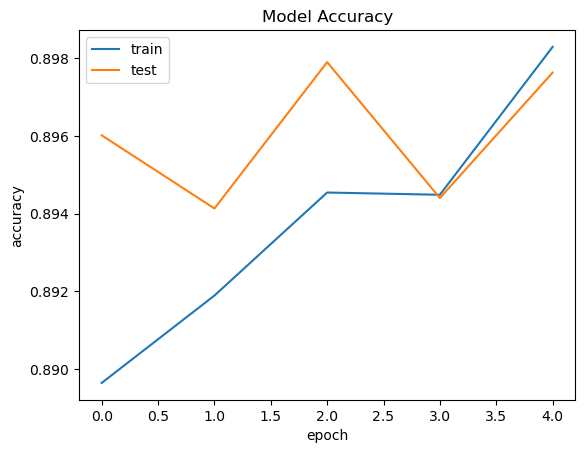

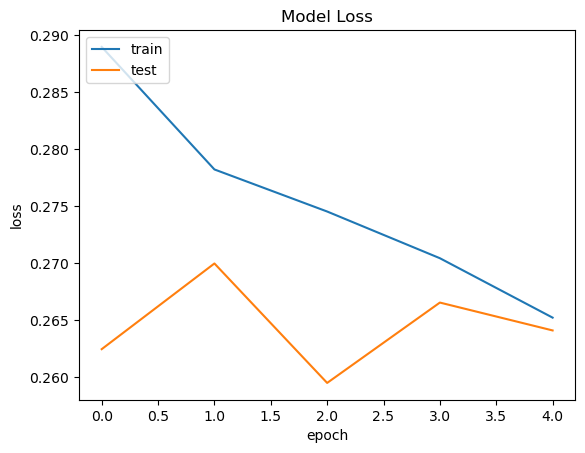

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

233/233 [==============================] - 46s 193ms/step


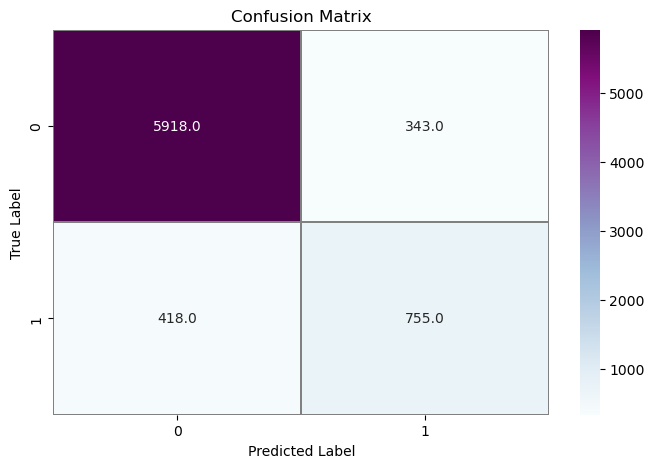

In [24]:
from sklearn.metrics import accuracy_score
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1) 
#accuracy=accuracy_score(y_true=Y_true, y_pred=Y_pred)
#print(accuracy)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


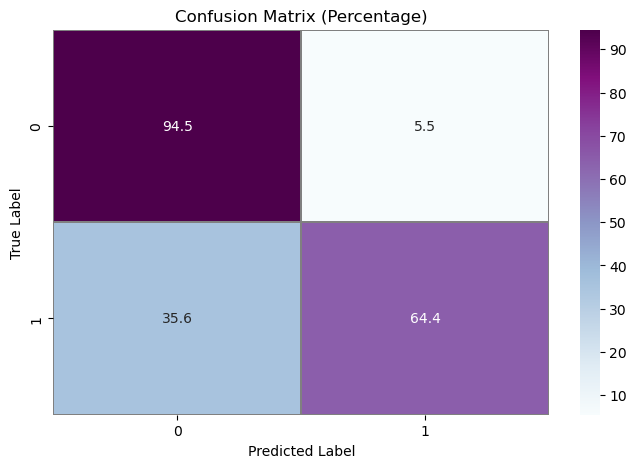

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix
#Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1) 
Y_true = np.argmax(Y_test, axis=1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

In [26]:
model.evaluate(X_test,Y_test)

233/233 [==============================] - 45s 192ms/step - loss: 0.2641 - accuracy: 0.8976


[0.2640831768512726, 0.8976324796676636]

In [27]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred))

233/233 [==============================] - 44s 190ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6261
           1       0.69      0.64      0.66      1173

    accuracy                           0.90      7434
   macro avg       0.81      0.79      0.80      7434
weighted avg       0.90      0.90      0.90      7434



In [28]:
print(f"Train Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Test Accuracy: {model.evaluate(X_test, Y_test)[1]:.4f}")
val_loss, val_acc = model.evaluate(X_test, Y_test)
print(f"Validation Accuracy: {val_acc:.4f}")

Train Accuracy: 0.8983
233/233 [==============================] - 45s 192ms/step - loss: 0.2641 - accuracy: 0.8976
Test Accuracy: 0.8976
233/233 [==============================] - 44s 191ms/step - loss: 0.2641 - accuracy: 0.8976
Validation Accuracy: 0.8976


# Testing

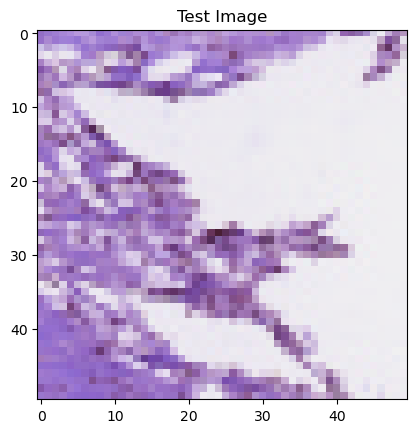

In [30]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])
    
index = 1000
img_plot(X_test, index)

In [31]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])
    
index = 900
input = X_test[index:index+1]
pred = model.predict(input)[0].argmax()
label = Y_test[index].argmax()
print('Predicted Value using  cnn model',pred)
print("True Value",label)


1/1 [==============================] - 0s 57ms/step
Predicted Value using  cnn model 0
True Value 0


1/1 [==============================] - 0s 52ms/step
[[0.904359   0.11362529]]
0


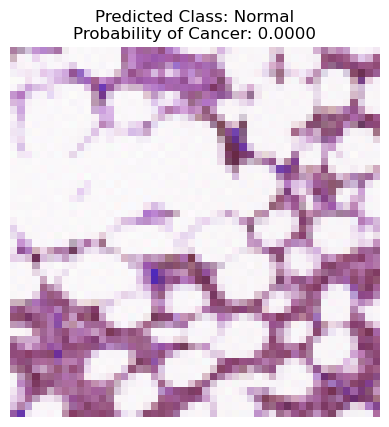

In [32]:
# Read the image in color mode
#     n_img = cv2.imread(img, cv2.IMREAD_COLOR)
#     # Resize the image to a fixed size (50x50 pixels) using linear interpolation
#     n_img_size = cv2.resize(n_img, (50, 50), interpolation=cv2.INTER_LINEAR)
#     # Append the resized image and label 0 (indicating non-cancer) to the 'non_img_arr'
#     non_img_arr.append([n_img_size, 0])

import cv2

# Directory containing the images
imgs_dir = glob.glob('/kaggle/input/breast-histopathology-images', recursive=True)

# Example image path
image_path = '/kaggle/input/breast-histopathology-images/10253/1/10253_idx5_x701_y401_class1.png'

# Define a function to load and preprocess an image
def load_and_preprocess_image(image_path, target_size=(50, 50)):
    try:
        # Load and preprocess the image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.IMREAD_COLOR)  # Convert BGR to RGB format
        img = cv2.resize(img, target_size,interpolation= cv2.INTER_LINEAR)  # Resize to your target size
        img_array = img / 255.0  # Normalize pixel values
       
        return img
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

# Load and preprocess the example image
img_array = load_and_preprocess_image(image_path)

if img_array is not None:
    # Create a batch for prediction (even if it's a single image)
    img_batch = np.expand_dims(img_array, axis=0)
    
    # Make predictions
    predictions = model.predict(img_batch)
    print(predictions)
    # Assuming your model predicts binary probabilities, you can get the probability for "Cancer" class
    cancer_probability = predictions[0].argmax()  # Assuming "Cancer" is the first class
    print(cancer_probability)
    # Get the predicted class label
    predicted_class = "Cancer" if cancer_probability >= 0.5 else "Normal"

#   Plot the image and display the predicted class and probability
    plt.imshow(img_array)
    plt.title(f'Predicted Class: {predicted_class}\nProbability of Cancer: {cancer_probability:.4f}')
    plt.axis('off')
    plt.show()
else:
    print("Image loading and preprocessing failed.")